In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.linalg import solve_continuous_lyapunov
from scipy.stats import multivariate_normal, norm 
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
np.set_printoptions(precision=3)
from itertools import groupby

In [15]:
class simple_model(): 
    
    def __init__(self, sigma, r):
        self.rv =  norm(0, sigma)
        self.rvm =  norm(0, r*sigma)
        
    def evolve(self, T, dt, n_frames):
        y = 0 
        res = np.zeros((n_frames))
        true_traj = np.zeros((n_frames))
        for i in range(n_frames):
            for j in range(int(T/n_frames/dt)):
                y = self._update(y, dt)
            res[i] = y + self.rvm.rvs()
            true_traj[i] = y 
        return res, true_traj 

    def _update(self, y, dt):
        det = - y * dt 
        sto = np.sqrt(dt)*self.rv.rvs()
        y += det + sto 
        return y 
        

In [55]:
T = 5e3
dt = 5e-3
n_frames = int(1*T) 

sigma = 0.2 
r = 1

m = simple_model(sigma, r)
res, true_traj = m.evolve(T, dt, n_frames)

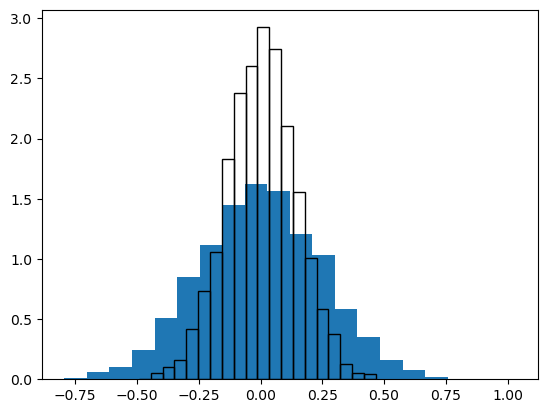

In [56]:
plt.hist(res, bins=20, density=True)
plt.hist(true_traj, bins=20, fill=False, density=True)
plt.show() 

In [53]:
class inference():
    
    def __init__(self):
        pass 
    
    def inf(self, guess, trajs, dt, bounds=None, brute_force=False, method='trust-constr'):   
        cost = lambda x: self._minuslogP(x, trajs, dt)
        if bounds is None: 
            bounds = [[1e-6, 10]]*2
        if brute_force: 
            res = brute(cost, bounds, Ns=100)
            MAP, cost = res[0], res[1]
        else: 
            res = minimize(cost, guess, bounds=bounds, method=method)
            MAP, cost = res.x, res.fun 
        return MAP, cost
           
    def _minuslogP(self, params, traj, dt):
        '''
        traj: 2 x T 
        '''

        sigma = params[0] 
        r = params[1] 

        f = 1/(1+2*r**2)
        evo = np.exp(-dt) 
        cov = (1-evo**2)*sigma**2/2 
        cov += (1+evo**2/(1+2*r**2))*(r*sigma)**2 
        norm = - np.log(cov)
        

        T = len(traj)-1
        xm = evo*f*traj[:-1]
        diff = (traj[1:] - xm)
        minuslogp = np.sum(diff**2)/cov/2
        minuslogp -= T*norm/2
        return minuslogp

In [54]:
inf = inference()
guess = [1, 1]
MAP, cost = inf.inf(guess, res, 1, brute_force=False)
print(MAP, cost)
print([sigma, r], inf._minuslogP([sigma, r], res, 1))

[0.194 1.031] -2763.8856430698124
[0.2, 1] -2763.6894260673953
